# PINN for Plasma Problem

This notebook is an attempt to solve the plasma continuity equation using a physics-informed neural network (PINN). The goal is to obtain the transport coefficients $D$ and $V$ from data.

$$ \frac{\partial \mathcal{V}}{\partial \rho} \frac{\partial n_e}{\partial t} = \frac{\partial}{\partial \rho} \frac{\partial \mathcal{V}}{\partial \rho} \left(   \langle (\nabla \rho)^2 \rangle D \frac{\partial n_e}{\partial \rho} -  \langle \nabla \rho \rangle V n_e \right) + \frac{\partial \mathcal{V}}{\partial \rho} \left( S - \frac{n_e}{\tau_{||}} \right) $$

where $\rho$ is the radial coordinate, $t$ is time, $\mathcal{V}$ is the plasma volume, $n_e$ is the electron density, $\langle (\nabla \rho)^2 \rangle$ and $\langle \nabla \rho \rangle$ are flux surface averaging terms, $D$ is the electron diffusion coefficient, $V$ is the convection velocity, $S$ is the particle source term, and $\tau_{||}$ is the parrallel confinement time.

### Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch

### Load data

In [17]:
# Load dataset
path_to_datafile = 'data/100134_1.8MW_55s_aaro_5_3.npz'
data_files = np.load(path_to_datafile, allow_pickle=True)
data = {key: data_files[key] for key in data_files.files}

# Unpack
prob = data['prob'][()]
x = prob['x']
t = prob['tout']
prob = data['prob'][()]
x = prob['x']                        # Normalized poloidal flux
D = prob['D']                        # Diffusion coefficient
V = prob['V']                        # Pinch velocity
S = prob['S']                        # Source term
dVdx = prob['dVdx']                  # Volume expansion term
g1 = prob['g1']                      # ⟨∇ρ⟩
g2 = prob['g2']                      # ⟨(∇ρ)^2⟩
bc = prob['bc']                      # Boundary condition at psi_n ≈ 1.106 (or 1.0 ???)
n0 = prob['n0']                      # Initial density
t = prob['tout']                     # Time
itaupar = prob['itaupar']            # Parallel loss time

# Solution data
sol = data['sol'][()]
ne = sol['ne']                       # Electron density (Found solution)

### Define Feedforward Neural Network

In [18]:
class FNN(torch.nn.Module):
    def __init__(self, dims, hidden_act=torch.nn.Tanh(), output_act=torch.nn.Identity(), weight_init=torch.nn.init.xavier_normal_, bias_init=torch.nn.init.zeros_):
        super(FNN, self).__init__()

        self.dims = dims

        input_dim = dims[0]
        output_dim = dims[-1]
        hidden_dims = dims[1:-1]

        self.layers = torch.nn.ModuleList()
        in_dim = input_dim
        for out_dim in hidden_dims:
            self.layers.append(torch.nn.Linear(in_dim, out_dim)); self.layers.append(hidden_act)
            in_dim = out_dim
        self.layers.append(torch.nn.Linear(in_dim, output_dim))
        self.layers.append(output_act)
            
        self.inititialize_weights(weight_init, bias_init)

    def inititialize_weights(self, weight_init, bias_init):
        if weight_init:
            for layer in self.layers:
                if isinstance(layer, torch.nn.Linear):
                    weight_init(layer.weight)
        if bias_init:
            for layer in self.layers:
                if isinstance(layer, torch.nn.Linear):
                    bias_init(layer.bias)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Make smooth approximations of geometric terms
Allow gradient computation with autograd.

In [19]:
S_net = FNN([2, 20, 20, 20, 20, 1], output_act=torch.nn.Softplus())
D_net = FNN([1, 20, 20, 1], output_act=torch.nn.Softplus())
V_net = FNN([1, 20, 20, 1])
dVdx_net = FNN([1, 20, 20, 1], output_act=torch.nn.Softplus())
g1_net = FNN([1, 20, 20, 1], output_act=torch.nn.Softplus())
g2_net = FNN([1, 20, 20, 1], output_act=torch.nn.Softplus())
itaupar_net = FNN([1, 20, 20, 1], output_act=torch.nn.Softplus())
ne_net = FNN([2, 20, 20, 20, 20, 1], output_act=torch.nn.Softplus())

In [20]:
def approximate(x, y, net):
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
    criterion = torch.nn.MSELoss()
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    for epoch in range(100000):
        optimizer.zero_grad()
        y_pred = net(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        if epoch % 10000 == 0:
            print(f'Epoch {epoch}, loss {loss.item()}')

# approximate(x, dVdx, dVdx_net)
# approximate(x, g1, g1_net)
# approximate(x, g2, g2_net)
# approximate(x, itaupar[:, 0], itaupar_net)

In [21]:
dVdx_net.load_state_dict(torch.load('data/dVdx_net.pt', weights_only=True))
g1_net.load_state_dict(torch.load('data/g1_net.pt', weights_only=True))
g2_net.load_state_dict(torch.load('data/g2_net.pt', weights_only=True))
itaupar_net.load_state_dict(torch.load('data/itaupar_net.pt', weights_only=True))
S_net.load_state_dict(torch.load('data/S_net.pt', weights_only=True))
D_net.load_state_dict(torch.load('data/D_net.pt', weights_only=True))
V_net.load_state_dict(torch.load('data/V_net.pt', weights_only=True))
ne_net.load_state_dict(torch.load('data/ne_net.pt', weights_only=True))

<All keys matched successfully>

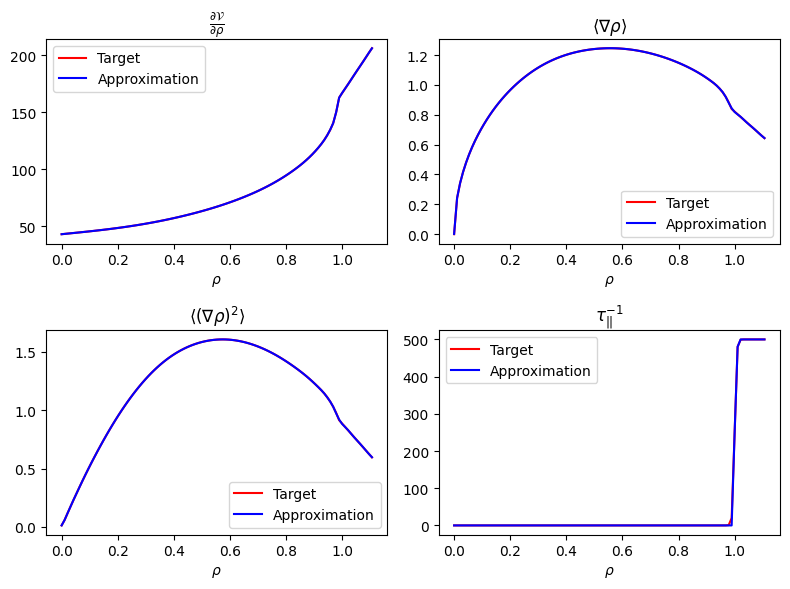

In [22]:
plt.subplots(2, 2, figsize=(8, 6))
for i, (net, y_true, name) in enumerate([(dVdx_net, dVdx, r'$\frac{\partial \mathcal{V}}{\partial \rho}$'), (g1_net, g1, r'$\langle \nabla \rho \rangle$'), (g2_net, g2, r'$\langle (\nabla \rho)^2 \rangle$'), (itaupar_net, itaupar[:, 0], r'$\tau_{||}^{-1}$')]):
    x_pred = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
    y_pred = net(x_pred).detach().numpy()
    plt.subplot(2, 2, i+1)
    plt.plot(x, y_true, label='Target', color='red')
    plt.plot(x, y_pred, label='Approximation', color='blue')
    plt.xlabel(r'$\rho$')
    plt.title(name)
    plt.legend()
plt.tight_layout()
# plt.savefig('tokamak_approximation.pdf', format='pdf', bbox_inches='tight')
plt.show()

<Figure size 600x400 with 0 Axes>

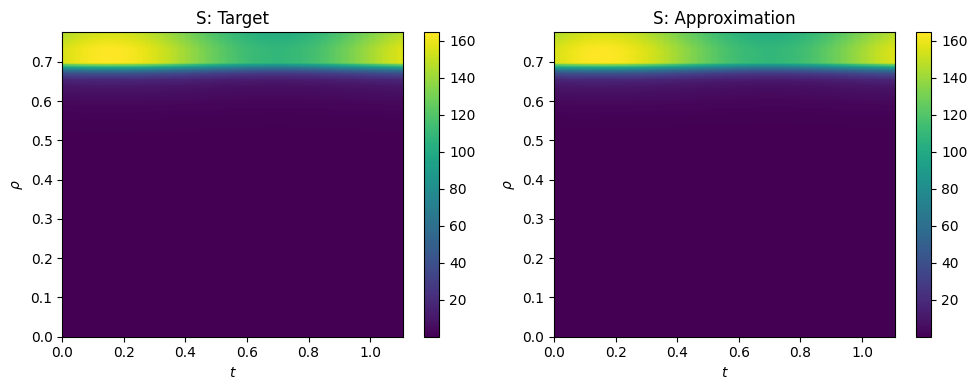

In [23]:
plt.figure(figsize=(6, 4))
X, T = torch.meshgrid(torch.tensor(x, dtype=torch.float32), torch.tensor(t, dtype=torch.float32), indexing='ij')
Z = torch.stack([X.flatten(), T.flatten()], dim=1)
S_pred = S_net(Z).detach().numpy().reshape(X.shape)
# ne_pred = ne_net(Z).detach().numpy().reshape(X.shape)

plt.subplots(1, 2, figsize=(10, 4))
for i, (S_true, name) in enumerate([(S, 'S: Target'), (S_pred, 'S: Approximation')]):
    plt.subplot(1, 2, i+1)
    plt.imshow(S_true, aspect='auto', origin='lower', extent=[x[0], x[-1], t[0], t[-1]])
    plt.colorbar()
    plt.ylabel(r'$\rho$')
    plt.xlabel(r'$t$')
    plt.title(name)
plt.tight_layout()
plt.show()

### Define PINN model

In [24]:
class PlasmaPINN(torch.nn.Module):
    
    def __init__(self, dVdx_net, g1_net, g2_net, itaupar_net, S_net):
        super(PlasmaPINN, self).__init__()

        # Define network of geometric quantities
        self.dVdx_net = dVdx_net
        self.g1_net = g1_net
        self.g2_net = g2_net
        self.itaupar_net = itaupar_net
        self.S_net = S_net
        self.ne_net = ne_net

        # Initialize the neural networks
        self.D_net = FNN([1, 20, 20, 1]) # Assumes D is time independent
        self.V_net = FNN([1, 20, 20, 1]) # Assumes V is time independent
        # self.S_net = FNN([1, 20, 20, 1]) # Assumes S is time independent
        # self.ne_net = FNN([2, 20, 20, 20, 20, 1])

    def to(self, device):
        super().to(device)
        self.dVdx_net.to(device)
        self.g1_net.to(device)
        self.g2_net.to(device)
        self.itaupar_net.to(device)
        self.S_net.to(device)
        self.D_net.to(device)
        self.V_net.to(device)
        self.ne_net.to(device)

        self.collocation_points = self.collocation_points.to(device)
        self.boundary_points_lower = self.boundary_points_lower.to(device)
        self.boundary_points_upper = self.boundary_points_upper.to(device)
        self.data_points = self.data_points.to(device)
        self.data_values = self.data_values.to(device)
        self.boundary_values_upper = self.boundary_values_upper.to(device)


    def get_trainable_parameters(self):
        return list(self.D_net.parameters()) + list(self.V_net.parameters()) + list(self.S_net.parameters())


    def pde_residuals(self):

        # Model predictions
        D = self.D_net(self.collocation_points[:, 0:1])
        V = self.V_net(self.collocation_points[:, 0:1])
        ne = self.ne_net(self.collocation_points)

        # Compute geometric quantities
        dVdx = self.dVdx_net(self.collocation_points[:, 0:1])
        g1 = self.g1_net(self.collocation_points[:, 0:1])
        g2 = self.g2_net(self.collocation_points[:, 0:1])
        itaupar = self.itaupar_net(self.collocation_points[:, 0:1])
        S = self.S_net(self.collocation_points)

        # Compute gradients
        dnedz = torch.autograd.grad(ne, self.collocation_points, grad_outputs=torch.ones_like(ne), create_graph=True)[0]
        dnedx = dnedz[:, 0:1]
        dnedt = dnedz[:, 1:2]

        # Compute individual PDE terms
        lhs = dVdx * dnedt

        flux = dVdx * (g2 * D * dnedx - g1 * V * ne)
        rhs1 = torch.autograd.grad(flux, self.collocation_points, grad_outputs=torch.ones_like(flux), create_graph=True)[0][:, 0:1]
        rhs2 = dVdx * (S - ne * itaupar)

        # Residuals
        residuals = lhs - (rhs1 + rhs2)
        norm = torch.maximum(torch.abs(lhs), torch.maximum(torch.abs(rhs1), torch.abs(rhs2)))

        # Normalize residuals to stabilize training
        return residuals / (norm + 1e-8)
    

    def boundary_residual(self):

        # Lower boundary condition (No flux)

        # Model predictions
        D = self.D_net(self.boundary_points_lower[:, 0:1])
        V = self.V_net(self.boundary_points_lower[:, 0:1])
        ne = self.ne_net(self.boundary_points_lower)
        dnedz = torch.autograd.grad(ne, self.boundary_points_lower, grad_outputs=torch.ones_like(ne), create_graph=True)[0]
        dnedx = dnedz[:, 0:1]

        # Compute geometric quantities
        dVdx = self.dVdx_net(self.boundary_points_lower[:, 0:1])
        g1 = self.g1_net(self.boundary_points_lower[:, 0:1])
        g2 = self.g2_net(self.boundary_points_lower[:, 0:1])
       
        # Compute flux
        res_lower = dVdx * (g2 * D * dnedx - g1 * V * ne)

        # Upper boundary condition
        ne = self.ne_net(self.boundary_points_upper)
        res_upper = ne - self.boundary_values_upper

        return res_lower, res_upper
    

    def data_residual(self):

        # Model predictions
        ne = self.ne_net(self.data_points)

        # Compute residuals
        return ne - self.data_values


    def loss(self):

        # Get residuals
        pde_residuals = self.pde_residuals()
        boundary_residuals_lower, boundary_residuals_upper = self.boundary_residual()
        data_residuals = self.data_residual()

        # Compute loss
        pde_loss = torch.mean(pde_residuals**2)
        boundary_loss_lower = torch.mean(boundary_residuals_lower**2)
        boundary_loss_upper = torch.mean(boundary_residuals_upper**2)
        data_loss = torch.mean(data_residuals**2)

        # Total loss
        loss = pde_loss + boundary_loss_lower + boundary_loss_upper + data_loss

        return loss, pde_loss, boundary_loss_lower, boundary_loss_upper, data_loss
        


# Define the model
model = PlasmaPINN(dVdx_net, g1_net, g2_net, itaupar_net, S_net)
        

### Setup problem

In [25]:
# Collocation points
Nc = 10000
sobol = torch.quasirandom.SobolEngine(dimension=2)
Zc = sobol.draw(n=Nc, dtype=torch.float32)
Zc[:, 0] = Zc[:, 0] * (x[-1] - x[0]) + x[0]
Zc[:, 1] = Zc[:, 1] * (t[-1] - t[0]) + t[0]

# Boundary points
Nb = 100
tb = torch.linspace(t[0], t[-1], Nb)
Zb_lower = torch.zeros(Nb, 2)
Zb_lower[:, 1] = tb
Zb_upper = torch.ones(Nb, 2)*x[-1]
Zb_upper[:, 1] = tb
Ub_upper = torch.ones(Nb, 1)*bc[1]

# Data points
X, T = torch.meshgrid(torch.tensor(x, dtype=torch.float32), torch.tensor(t, dtype=torch.float32), indexing='ij')
Zd = torch.stack([X.flatten(), T.flatten()], dim=1)
Ud = torch.tensor(ne.flatten(), dtype=torch.float32).unsqueeze(1)

# Set points
model.collocation_points = Zc.requires_grad_(True)
model.boundary_points_lower = Zb_lower.requires_grad_(True)
model.boundary_points_upper = Zb_upper
model.boundary_values_upper = Ub_upper
model.data_points = Zd
model.data_values = Ud

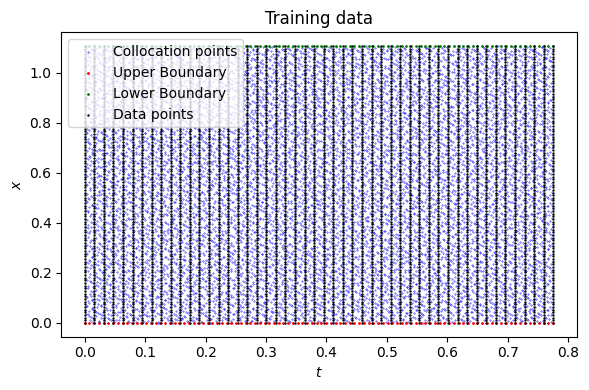

In [26]:
# Plot datapoints
plt.figure(figsize=(6, 4))
plt.scatter(Zc[:, 1].detach(), Zc[:, 0].detach(), s=0.1, label='Collocation points', color='blue')
plt.scatter(Zb_lower[:, 1].detach(), Zb_lower[:, 0].detach(), s=1, label='Upper Boundary', color='red')
plt.scatter(Zb_upper[:, 1], Zb_upper[:, 0], s=1, label='Lower Boundary', color='green')
plt.scatter(Zd[:, 1], Zd[:, 0], s=0.5, label='Data points', color='black')
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.legend()
plt.title('Training data')
plt.tight_layout()
plt.show()

In [27]:
# model.D_net = D_net
# model.V_net = V_net

### Training loop

In [28]:
losses = dict()
beta = 1.0

In [29]:
class SoftAdapt(torch.nn.Module):
    def __init__(self, beta=0.0, loss_weighted=False):
        super(SoftAdapt, self).__init__()
        self.beta = beta
        self.loss_weigthed = loss_weighted
        self.prev_losses = 0.0

    def forward(self, losses):
        self.prev_losses = losses
        s = losses - self.prev_losses
        t = torch.exp(self.beta*s)
        new_lambdas = losses*t / torch.sum(losses*t) if self.loss_weigthed else t / torch.sum(t)
        return new_lambdas

sa = SoftAdapt(beta=beta, loss_weighted=False)

optimizer = torch.optim.Adam(model.get_trainable_parameters(), lr=1e-3)

In [30]:
lambdas = [1.0, 1.0, 1.0, 1.0]
model.to('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(100000):
    optimizer.zero_grad()
    loss, pde_loss, boundary_loss_lower, boundary_loss_upper, data_loss = model.loss()
    loss = lambdas[0]*pde_loss + lambdas[1]*boundary_loss_lower + lambdas[2]*boundary_loss_upper + lambdas[3]*data_loss
    losses.setdefault('loss', []).append(loss.item())
    losses.setdefault('pde_loss', []).append(pde_loss.item())
    losses.setdefault('boundary_loss_lower', []).append(boundary_loss_lower.item())
    losses.setdefault('boundary_loss_upper', []).append(boundary_loss_upper.item())
    losses.setdefault('data_loss', []).append(data_loss.item())
    losses.setdefault('lambda_pde', []).append(lambdas[0])
    losses.setdefault('lambda_boundary_lower', []).append(lambdas[1])
    losses.setdefault('lambda_boundary_upper', []).append(lambdas[2])
    losses.setdefault('lambda_data', []).append(lambdas[3])
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        
        # Apply softadapt
        lambdas = sa(torch.tensor([pde_loss, boundary_loss_lower, boundary_loss_upper, data_loss]))

        print(f"Epoch {epoch}, loss {loss.item():.2e}, pde_loss {pde_loss.item():.2e}, "
      f"boundary_loss_lower {boundary_loss_lower.item():.2e}, boundary_loss_upper {boundary_loss_upper.item():.2e}, "
      f"data_loss {data_loss.item():.2e}")
model.to('cpu')

Epoch 0, loss 2.16e+00, pde_loss 2.15e+00, boundary_loss_lower 0.00e+00, boundary_loss_upper 7.78e-04, data_loss 1.67e-05
Epoch 100, loss 2.22e-01, pde_loss 8.87e-01, boundary_loss_lower 1.77e-04, boundary_loss_upper 7.78e-04, data_loss 1.67e-05
Epoch 200, loss 2.19e-01, pde_loss 8.74e-01, boundary_loss_lower 2.01e-04, boundary_loss_upper 7.78e-04, data_loss 1.67e-05
Epoch 300, loss 2.17e-01, pde_loss 8.67e-01, boundary_loss_lower 2.23e-04, boundary_loss_upper 7.78e-04, data_loss 1.67e-05
Epoch 400, loss 2.15e-01, pde_loss 8.59e-01, boundary_loss_lower 2.54e-04, boundary_loss_upper 7.78e-04, data_loss 1.67e-05
Epoch 500, loss 2.13e-01, pde_loss 8.51e-01, boundary_loss_lower 2.96e-04, boundary_loss_upper 7.78e-04, data_loss 1.67e-05
Epoch 600, loss 2.11e-01, pde_loss 8.42e-01, boundary_loss_lower 3.71e-04, boundary_loss_upper 7.78e-04, data_loss 1.67e-05
Epoch 700, loss 2.08e-01, pde_loss 8.32e-01, boundary_loss_lower 4.83e-04, boundary_loss_upper 7.78e-04, data_loss 1.67e-05
Epoch 800,

### Plot results

In [31]:
# model.D_net.load_state_dict(torch.load('models/D_net_plasma_naive.pt', weights_only=True))
# model.V_net.load_state_dict(torch.load('models/V_net_plasma_naive.pt', weights_only=True))
# model.S_net.load_state_dict(torch.load('models/S_net_plasma_norm.pt', weights_only=True))

In [40]:
Zs = torch.stack([torch.tensor(x, dtype=torch.float32), torch.zeros_like(torch.tensor(x, dtype=torch.float32))], dim=1)
S_pred = model.S_net(Zs).detach().numpy().flatten()

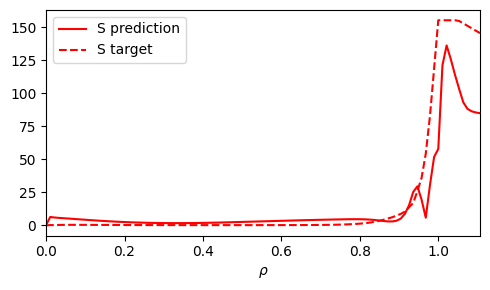

In [53]:
model.to('cpu')
plt.figure(figsize=(5,3))
# plt.axvline(x=1.0, color='black', linestyle='--', lw=1)
plt.plot(x, S_pred, label='S prediction', color='red')
plt.plot(x, S[:, 0], '--', label='S target', color='red')
plt.xlabel(r'$\rho$')
plt.xlim([x[0], x[-1]])
plt.legend()
plt.savefig('tokamak_S_cheat.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

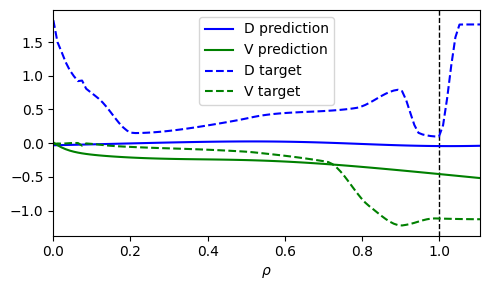

In [ ]:
model.to('cpu')
plt.figure(figsize=(4,3))
D_pred = model.D_net(torch.tensor(x, dtype=torch.float32).unsqueeze(1)).detach().numpy()
V_pred = model.V_net(torch.tensor(x, dtype=torch.float32).unsqueeze(1)).detach().numpy()
ne_pred = model.ne_net(Zd).detach().numpy().reshape(X.shape)
plt.axvline(x=1.0, color='black', linestyle='--', lw=1)
plt.plot(x, -D_pred, label='D prediction', color='blue')
plt.plot(x, -V_pred, label='V prediction', color='green')
plt.plot(x, D[:, 0], label='D target', linestyle='--', color='blue')
plt.plot(x, V[:, 0], label='V target', linestyle='--', color='green')
plt.xlabel(r'$\rho$')
plt.legend()
plt.xlim([x[0], x[-1]])
# plt.savefig('tokamak_DV_sa.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()



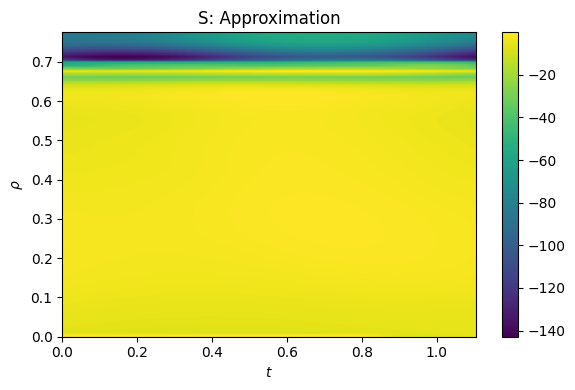

In [35]:
S_pred = model.S_net(Zd).detach().numpy().reshape(X.shape)
plt.figure(figsize=(6, 4))
plt.imshow(-S_pred, aspect='auto', origin='lower', extent=[x[0], x[-1], t[0], t[-1]])
plt.colorbar()
plt.ylabel(r'$\rho$')
plt.xlabel(r'$t$')
plt.title('S: Approximation')
plt.tight_layout()
plt.show()

In [36]:
name = 'plasma_cheating'

In [37]:
torch.save(model.D_net.state_dict(), 'models/D_net_' + name + '.pt')
torch.save(model.V_net.state_dict(), 'models/V_net_' + name + '.pt')
torch.save(model.S_net.state_dict(), 'models/S_net_' + name + '.pt')

In [38]:
np.save(name+'.npy', np.stack((losses['loss'], losses['pde_loss'], losses['boundary_loss_lower'], losses['boundary_loss_upper'], losses['data_loss']), axis=1))